In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
from underwriting import client_surveillance_jupyter

In [4]:
COMPANY_IDENTIFIER = ['CSC']
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [5]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

In [6]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C10-0000670-LIC,Retailer,"DISPLEASED MARMOT, LLC",True,Active,CA-04155,Retailer,977dbaa4-81e5-4c4d-afd7-622506a05e93,48981d0b-5ccc-4ecc-85d4-2729a7caf7f8
1,CA,C10-0000918-LIC,Retailer,Gnarly Narwhal LLC,True,Active,CA-06173,Retailer,977dbaa4-81e5-4c4d-afd7-622506a05e93,456fa190-5ae9-4d6d-9cdb-828d21062c02


## Check download status summaries

In [7]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [8]:
license_numbers

array(['C10-0000670-LIC', 'C10-0000918-LIC'], dtype=object)

In [9]:
bad_download_history = client_surveillance_jupyter.check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license C10-0000670-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-05-16
Found bad download summary for license C10-0000670-LIC on date 2022-04-12

Verifying download summaries for license C10-0000918-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-05-16
Found bad download summary for license C10-0000918-LIC on date 2022-04-12

[FAILURE] Found a total of 2 bad download summaries


In [10]:
bad_download_history

defaultdict(list,
            {'C10-0000670-LIC': [datetime.date(2022, 4, 12)],
             'C10-0000918-LIC': [datetime.date(2022, 4, 12)]})

## Choose license numbers

In [11]:
# get list of retailer license numbers
license_numbers = list(company_licenses_dataframe[company_licenses_dataframe['license_category'].isin(['Retailer', 'Multiple'])]['license_number'].unique())
license_numbers

['C10-0000670-LIC', 'C10-0000918-LIC']

In [12]:
if COMPANY_IDENTIFIER == ['GRG']:
    license_numbers = ['C10-0000169-LIC']
elif COMPANY_IDENTIFIER == ['CSC']:
    license_numbers = ['C10-0000670-LIC']
license_numbers

['C10-0000670-LIC']

# License check

In [13]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C10-0000670-LIC,Retailer,"DISPLEASED MARMOT, LLC",True,Active,CA-04155,Retailer,977dbaa4-81e5-4c4d-afd7-622506a05e93,48981d0b-5ccc-4ecc-85d4-2729a7caf7f8
1,CA,C10-0000918-LIC,Retailer,Gnarly Narwhal LLC,True,Active,CA-06173,Retailer,977dbaa4-81e5-4c4d-afd7-622506a05e93,456fa190-5ae9-4d6d-9cdb-828d21062c02


In [14]:
company_state = list(company_licenses_dataframe['us_state'].unique())[0]
company_state

'CA'

In [15]:
retial_license_check_df = company_licenses_dataframe[company_licenses_dataframe['license_number'].isin(license_numbers)][['license_number','license_category','is_current','license_status','us_state']].reset_index(drop = True)
retial_license_check_df['license_check'] = ['YES' if retial_license_check_df['license_status'][i] == 'Active' or str(retial_license_check_df['is_current'][i]) == 'True' else 'NO' for i in range(len(retial_license_check_df))]
retial_license_check_df


,license_number,license_category,is_current,license_status,us_state,license_check
0,C10-0000670-LIC,Retailer,True,Active,CA,YES


## Pull data

In [16]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)

company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [17]:
#make sure we did pulled all location's data
company_incoming_transfer_packages_dataframe['license_number'].unique()

array(['C10-0000670-LIC'], dtype=object)

In [18]:
company_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C10-0000670-LIC'], dtype=object)

In [19]:
company_inventory_packages_dataframe['license_number'].unique()

array(['C10-0000670-LIC'], dtype=object)

## Unknown transfer packages

In [20]:
unknown_package_count = client_surveillance_jupyter.check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[SUCCESS] No unknown transfer packages!


0

## Receiver wholesale price coverage

In [21]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['receiver_wholesale_price'].notnull()].shape

(15518, 32)

In [22]:
company_incoming_transfer_packages_dataframe.shape

(15838, 32)

In [23]:
rwp_coverage = client_surveillance_jupyter.check_receiver_wholesale_price_coverage(company_incoming_transfer_packages_dataframe)


98.0% of incoming transfer packages have receiver wholesale price


## dedupe sales transactions

In [24]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [25]:
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [26]:
#check we have all locations
deduped_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C10-0000670-LIC'], dtype=object)

## Trxns missing incoming transfer packages

In [27]:
incoming_transfer_package_coverage,incoming_transfer_package_coverage_missing = client_surveillance_jupyter.check_incoming_transfer_package_coverage(company_incoming_transfer_packages_dataframe,deduped_sales_receipts_with_transactions_dataframe)

# transactions missing incoming transfer package: 179 (0.06900513105192346%)
# transactions total: 259401


In [28]:
month_to_missing_count = incoming_transfer_package_coverage_missing[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
month_to_missing_count


sales_month
2022-04    84
2022-05    66
dtype: int64

## Receipts missing metrc_sales_transactions

In [29]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [30]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.01
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    receipt_total_packages = receipt_transactions[0]['total_packages']

    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_package_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    # Check whether 'total_packages' field of sales receipt matches number of transactions related to receipt.
    if receipt_total_packages != len(receipt_transactions):
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# receipts with mismatching transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# receipts missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# receipts total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 17 (0.011944409313828815%)
# receipts total: 142326


In [31]:
company_sales_receipts_dataframe['sales_month'] = company_sales_receipts_dataframe['sales_datetime'].dt.strftime('%Y-%m')

<AxesSubplot:xlabel='sales_month'>

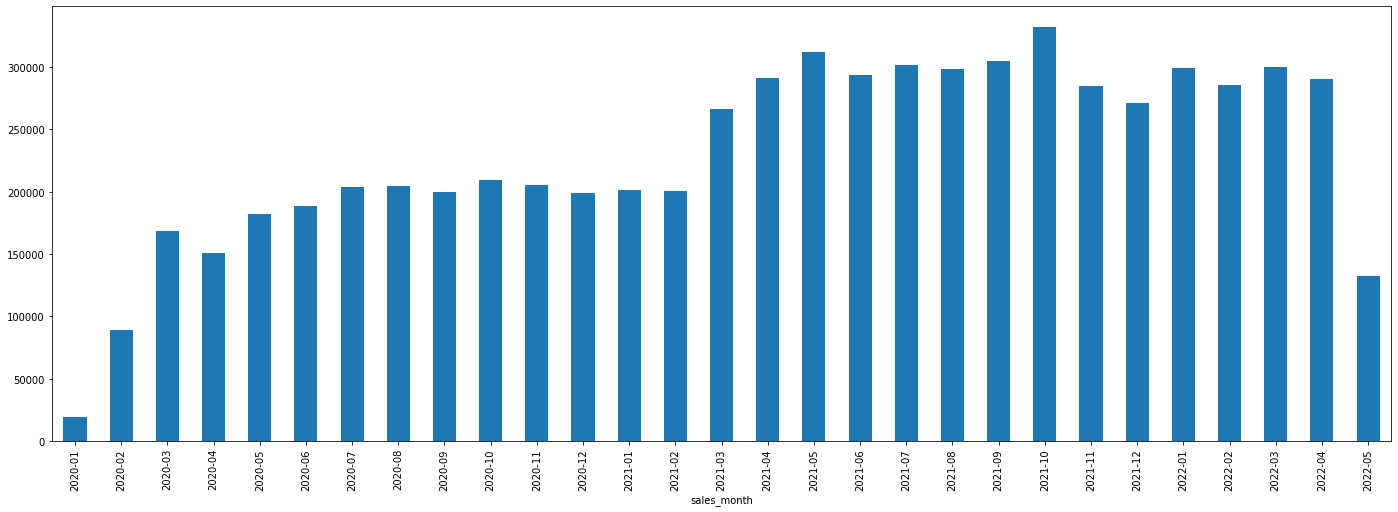

In [32]:
deduped_sales_receipts_with_transactions_dataframe.groupby(['sales_month'])['tx_total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

# Vendor churn

In [33]:
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-04-01'
VC_MONTH_LIST = ['2022-01-01','2022-02-01','2022-03-01','2022-04-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [34]:
license_numbers

['C10-0000670-LIC']

In [35]:
churn,vc_matrix = client_surveillance_jupyter.calculate_vendor_churn(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST)


In [36]:
churn_short,vc_matrix_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)


In [37]:
vc_matrix_short[vc_matrix_short['measure'] == 'Inactive'].sort_values(by = 'perc_total',ascending=False).shape

(10, 36)

In [38]:
churn_short

,year_month,%_inactive
year_month,,
2020-01-01,2020-01-01,0.000000
2020-02-01,2020-02-01,0.000000
2020-03-01,2020-03-01,0.000000
2020-04-01,2020-04-01,0.000000
2020-05-01,2020-05-01,0.000000
2020-06-01,2020-06-01,0.000000
2020-07-01,2020-07-01,0.000000
2020-08-01,2020-08-01,0.000000
2020-09-01,2020-09-01,0.000000


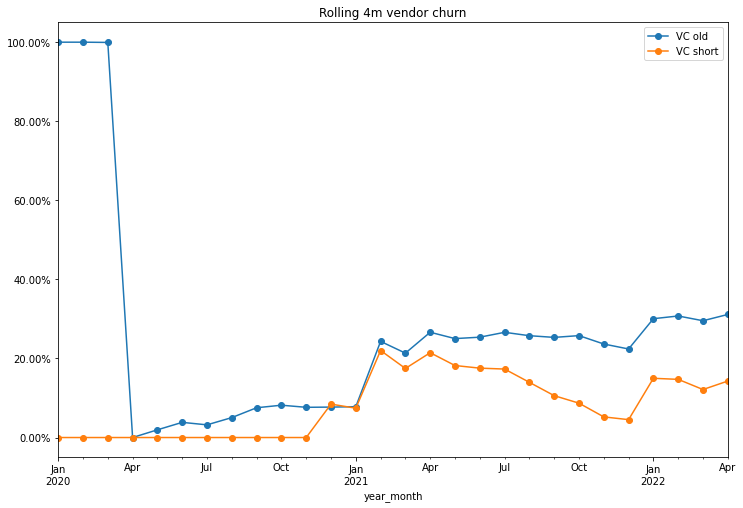

In [39]:
ax = churn['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC old')
ax = churn_short['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC short')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')
ax = plt.legend()

# Receiver wholesale price outlier check

In [40]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = client_surveillance_jupyter.check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


printing per unit incoming by package ID summary ...
max per unit incoming: 300.0 from package ID: 17867556
min per unit incoming: 2.5e-05 from package ID: 23383917



In [41]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(20)

Top 5 per unit incoming packages


,package_id,per_unit_incoming
0,17867556,300.0
1,21232050,175.0
2,3818405,132.0
3,14420347,110.0
4,14420349,110.0
5,10573640,95.0
6,12687519,95.0
7,13473738,90.0
8,12222006,90.0
9,2976797,90.0


In [42]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


Bottom 5 per unit incoming packages


,package_id,per_unit_incoming
15589,8825277,0.000050
15590,12638851,0.000049
15591,12252383,0.000039
15592,12252505,0.000039
15593,23383917,0.000025


In [43]:
# look at large cost items if any
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] > 10000]

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,receiver_wholesale_price_1,item_unit_weight,item_unit_weight_unit_of_measure_name,per_unit_incoming


# COGS analysis

In [44]:
df_in = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] <= 10000]
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [45]:
df_summary_simp,df_cogs_average_product = client_surveillance_jupyter.cogs_analysis(df_in,df_sales,'monthly',company_state)


In [46]:
df_summary_simp

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01,2020-01,19604.36,12693.82,6910.54,0.35,1153.0,22.0,1131,1.00,1153,22545.01,16121.15,6423.86,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28,NaN,NaN,NaN,NaN
2020-02,2020-02,89270.77,53022.74,36248.03,0.41,4851.0,253.0,4598,1.00,4851,102661.39,67338.88,35322.50,0.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.34,NaN,NaN,NaN,3.55
2020-03,2020-03,168489.95,94929.85,73560.10,0.44,7657.0,240.0,7417,0.99,7700,193763.44,120560.91,73202.53,0.38,0.40,NaN,NaN,160646.42,0.34,NaN,NaN,0.38,0.34,NaN,NaN,0.89
2020-04,2020-04,151237.68,89176.25,62061.43,0.41,6819.0,77.0,6742,1.00,6825,173923.33,113253.83,60669.50,0.35,0.42,NaN,NaN,237128.84,0.36,NaN,NaN,0.35,0.36,NaN,NaN,-0.10
2020-05,2020-05,182498.47,98091.79,84406.68,0.46,7909.0,37.0,7872,1.00,7925,209873.24,124576.57,85296.67,0.41,0.44,NaN,NaN,282197.89,0.38,NaN,NaN,0.41,0.38,NaN,NaN,0.21
2020-06,2020-06,188768.47,103873.86,84894.61,0.45,8169.0,117.0,8052,0.99,8223,217083.74,131919.80,85163.94,0.39,0.44,0.42,NaN,291141.89,0.38,0.36,NaN,0.39,0.38,0.36,NaN,0.03
2020-07,2020-07,203898.82,110125.63,93773.19,0.46,8835.0,60.0,8775,0.99,8881,234483.64,139859.55,94624.09,0.40,0.46,0.44,NaN,312091.27,0.40,0.38,NaN,0.40,0.40,0.38,NaN,0.08
2020-08,2020-08,204958.60,108635.72,96322.88,0.47,8771.0,119.0,8652,1.00,8771,235702.39,137967.36,97735.03,0.41,0.46,0.45,NaN,322635.20,0.40,0.39,NaN,0.41,0.40,0.39,NaN,0.01
2020-09,2020-09,199991.59,104974.25,95017.34,0.48,8266.0,11.0,8255,1.00,8266,229990.33,133317.30,96673.03,0.42,0.47,0.45,0.44,323735.60,0.41,0.40,0.38,0.42,0.41,0.40,0.38,-0.02


# Revenue change vs state

In [ ]:
if COMPANY_IDENTIFIER == ['NECC']:
    a = client_surveillance_jupyter.calculate_quarterly_sum_gmv_ma_short(df_summary_simp)
    a

In [ ]:
if COMPANY_IDENTIFIER == ['NECC']:
    round(a.dropna()['total'].sum(),2)

In [47]:
a = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp)
round(a.dropna()['total'].sum(),2)

15.4

In [48]:
a

,sum_gmv,sum_gmv_change,sum_gmv_change_ca,weight,variance,points,total
2020Q1,277365.08,NaN,NaN,NaN,NaN,10,NaN
2020Q2,522504.62,0.883815,NaN,NaN,NaN,10,NaN
2020Q3,608849.01,0.165251,NaN,NaN,NaN,10,NaN
2020Q4,613872.66,0.008251,0.17,0.04,-0.161749,-5,-0.2
2021Q1,668980.29,0.089770,-0.05,0.28,0.139770,10,2.8
2021Q2,897054.31,0.340928,0.02,0.52,0.320928,10,5.2
2021Q3,904885.24,0.008730,-0.11,0.76,0.118730,10,7.6
2021Q4,888428.89,-0.018186,0.00,1.00,-0.018186,0,0.0


# Inventory

In [49]:
today = date.today()
today

datetime.date(2022, 5, 16)

In [50]:
COMPANY_IDENTIFIER

['CSC']

In [51]:
license_numbers

['C10-0000670-LIC']

In [52]:
df_inventory_license = client_surveillance_jupyter.calculate_inventory_valuation(df_in,df_inventory,license_numbers,today)

In [53]:
df_inventory_license

,date,value,value_after_tax,total_incoming,total,coverage,license,legal_name
0,2022-05-16,749753.34,952186.74,15555,15716,0.99,[C10-0000670-LIC],"DISPLEASED MARMOT, LLC"


In [54]:
df_inventory_license_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales,df_inventory,license_numbers,today)

In [55]:
df_inventory_license_msrp

,date,value,total_incoming,total,coverage,license,legal_name
0,2022-05-16,1401921.98,13787,15716,0.88,[C10-0000670-LIC],"DISPLEASED MARMOT, LLC"


In [58]:
df_inventory_fresh,_ = client_surveillance_jupyter.calculate_inventory_valuation_fresh(df_in,df_inventory,license_numbers,today)

In [59]:
df_inventory_fresh

,date,value,value_after_tax,total_incoming,total,coverage,license,legal_name
0,2022-05-16,147617.03,187473.63,1491,1497,1.0,[C10-0000670-LIC],"DISPLEASED MARMOT, LLC"


# Create Template: updated

In [63]:
current_month = '2022-04'
full_score = 45

In [64]:
license_numbers

['C10-0000670-LIC']

In [65]:
template_new_ = client_surveillance_jupyter.create_template_update(a,df_summary_simp,df_inventory_license,df_inventory_license_msrp,df_inventory_fresh,churn_short,retial_license_check_df,license_numbers,company_state,current_month)



0.9889655172413793 True
0.99 True
2.1926360474766273 0
0.14284897314572717 10


In [66]:
template_new_

,0,1
0,legal name,"DISPLEASED MARMOT, LLC"
1,date,2022-04
2,license,[C10-0000670-LIC]
3,license is current,True
4,license is active,Active
5,license check,YES
6,metrc cogs coverage,0.99
7,metrc cogs coverage reliable ?,True
8,metrc inventory coverage,0.99
9,metrc inventory coverage reliable ?,True


# Output data 

In [67]:
license_numbers

['C10-0000670-LIC']

## others

In [68]:
# for only 1 license
license_number = license_numbers[0]
template_new_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_fresh.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_fresh.csv')
df_inventory_license_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_msrp.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')
#retial_license_check_df



# Appendix

In [ ]:
# def calculate_quarterly_sum_gmv_ma_short(cogs_analysis_df):

#     gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2021-09')&(cogs_analysis_df['date'] <= '2022-02')][['revenue_change']]
#     gmv_df['sum_gmv_change_ma'] = [-0.07,0.09,-0.11,0.02]
#     gmv_df['weight'] = [0.76,0.84,0.92,1]
#     gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_ma']
#     gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
#     gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
#     gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
#     return gmv_df
    